# Using the MNIST32 data set

In [37]:
import torch

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import pickle as pkl

from utils import lenet_model_and_optimizer, test, plain_gradient, input_x_gradient, integrated_gradients, project_into_tangent_space

In [2]:
device = "cuda"

## Load the data
##### The MNIST32 dataset is small, we store it in .pkl files

In [3]:
trainset = torch.utils.data.TensorDataset(*torch.load('../datasets/MNIST32_train.pkl'))
trainloader = DataLoader(trainset, batch_size=128, shuffle=True) 

valset = torch.utils.data.TensorDataset(*torch.load('../datasets/MNIST32_val.pkl'))
valloader = DataLoader(valset, batch_size=128, shuffle=False)

In [4]:
# We have 60000 train images and 10000 validation images
len(trainset), len(valset)

(60000, 10000)

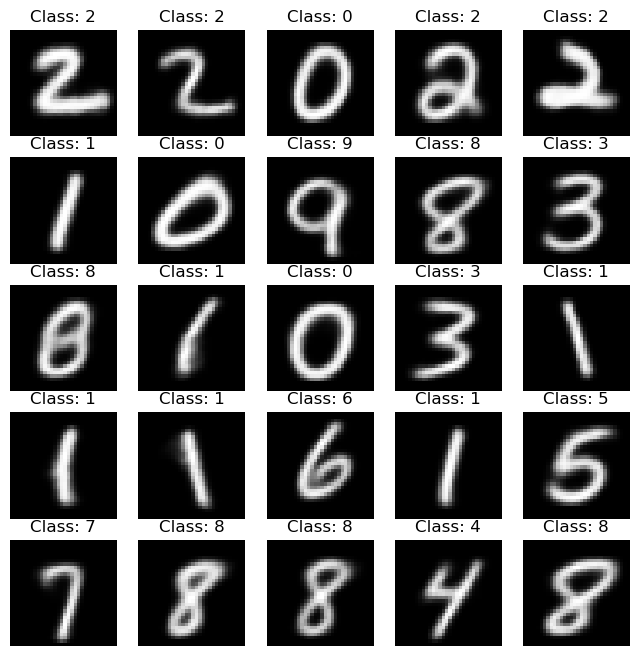

In [5]:
# visualize examples from the dataset
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(img[0, 0, :, :], cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Train a model

In [29]:
model, optimizer = lenet_model_and_optimizer(lr=1e-3)

# decrease the learning rate over time
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [30]:
model.to(device)
ce_loss = torch.nn.CrossEntropyLoss()

for i_epoch in range(50):   
    print(f' --- Epoch {i_epoch} --- ')
    # gradient descent on the dataset
    ce_loss = torch.nn.CrossEntropyLoss()
    model.train()
    train_loss = 0
    train_zero_one_loss = 0
    for img, label in trainloader:
        # take a single gradient step
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
    train_zero_one_loss = train_zero_one_loss / len(trainloader.dataset)
    print('Train Error: ', train_zero_one_loss)
    
    test(model, valloader, device)
    scheduler.step()

 --- Epoch 0 --- 
Train Error:  0.08245
Test Error:  0.0241
 --- Epoch 1 --- 
Train Error:  0.03381666666666667
Test Error:  0.0196
 --- Epoch 2 --- 
Train Error:  0.027133333333333332
Test Error:  0.016
 --- Epoch 3 --- 
Train Error:  0.024516666666666666
Test Error:  0.0165
 --- Epoch 4 --- 
Train Error:  0.0227
Test Error:  0.0124
 --- Epoch 5 --- 
Train Error:  0.020516666666666666
Test Error:  0.0146
 --- Epoch 6 --- 
Train Error:  0.019183333333333333
Test Error:  0.0121
 --- Epoch 7 --- 
Train Error:  0.0168
Test Error:  0.0118
 --- Epoch 8 --- 
Train Error:  0.016483333333333332
Test Error:  0.0123
 --- Epoch 9 --- 
Train Error:  0.015616666666666666
Test Error:  0.0132
 --- Epoch 10 --- 
Train Error:  0.012933333333333333
Test Error:  0.0096
 --- Epoch 11 --- 
Train Error:  0.0108
Test Error:  0.0093
 --- Epoch 12 --- 
Train Error:  0.010033333333333333
Test Error:  0.0085
 --- Epoch 13 --- 
Train Error:  0.00895
Test Error:  0.0082
 --- Epoch 14 --- 
Train Error:  0.009066666

## Or load the model used in the paper

In [50]:
model.load_state_dict(torch.load('../models/mnist32_lenet.pth'))
model.to(device)
model.eval()
test(model, valloader, device)

Test Error:  0.0065


0.0065

## 10.000 additional test points with tangent space

In [31]:
test_z, test_images, test_labels, test_tangent = pkl.load(open('../datasets/MNIST32_tangent.pkl', 'rb')) # In replicate-paper, this file is named mnist_monitor_32_10000.pkl
print('Number of obersevations:', len(test_z))
print('Latent dimensions:', test_z[0].shape)
print('Image dimensions:', test_images[0].shape)
print('Class dimensions:', test_labels[0].shape)
print('Tangent dimensions:', test_tangent[0].shape)

Number of obersevations: 10000
Latent dimensions: torch.Size([10])
Image dimensions: torch.Size([1, 32, 32])
Class dimensions: torch.Size([])
Tangent dimensions: (10, 32, 32)


In [15]:
testset = torch.utils.data.TensorDataset(test_images, test_labels)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

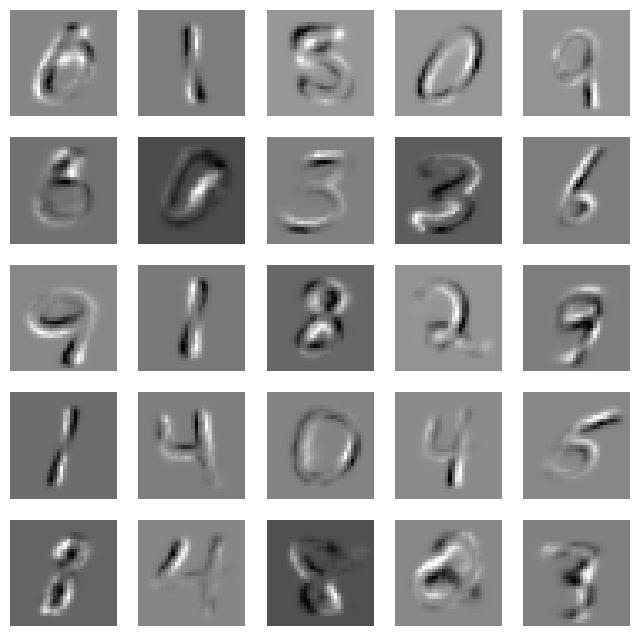

In [14]:
# visualize directions in the tangent space
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(len(test_z))
        axs[i,j].imshow(test_tangent[idx][0].reshape(32, 32), cmap='gray', interpolation='none')
        axs[i,j].axis('off')

## Compute feature attributions

In [51]:
grad_list, igx_list, int_grad_list = [], [], []
model.eval()
for idx, (img, label) in tqdm(enumerate(testloader)):
    img, label = img.to(device), label.to(device)
    grad = plain_gradient(model, img, target=label, device=device)
    grad_list.append(grad)
    ixg = input_x_gradient(model, img, target=label, device=device)
    igx_list.append(ixg)
    int_grad = integrated_gradients(model, img, target=label, device=device)
    int_grad_list.append(int_grad)

10000it [01:37, 102.78it/s]


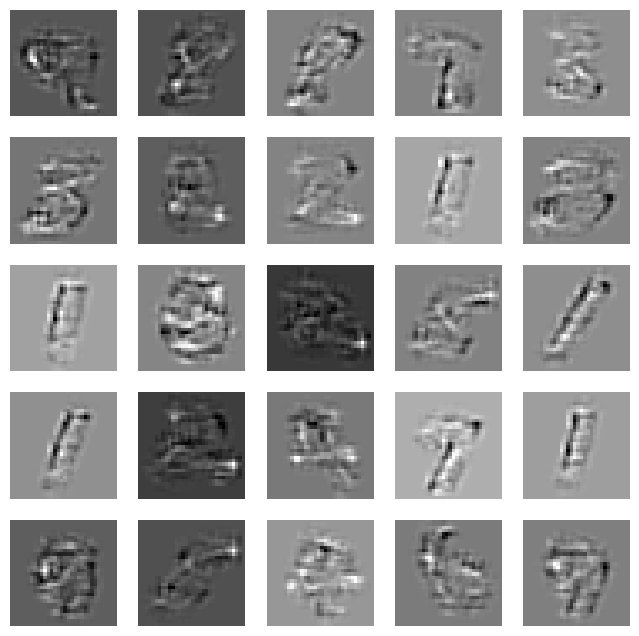

In [52]:
# visualize the attributions
fix, axs = plt.subplots(5, 5, figsize=(8, 8))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, 10000)
        attr = int_grad_list[idx]
        axs[i,j].imshow(attr, cmap='gray', interpolation='none')
        axs[i,j].axis('off')
plt.show()

## The alignment of attributions with the tangent space

In [53]:
frac_grad_its = []
frac_ixg_its = []
frac_int_grad_its = []
for idx in tqdm(range(10000)):
    # load the tanget space of the validation image
    tanget_space = test_tangent[idx]

    # compute projections into tangent space, and fraction in tangent space
    projection = project_into_tangent_space(tanget_space, grad_list[idx])
    frac_grad_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(grad_list[idx].flatten()))
    projection = project_into_tangent_space(tanget_space, igx_list[idx])
    frac_ixg_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(igx_list[idx].flatten()))
    projection = project_into_tangent_space(tanget_space, int_grad_list[idx])
    frac_int_grad_its.append(np.linalg.norm(projection.flatten()) / np.linalg.norm(int_grad_list[idx].flatten()))

100%|██████████| 10000/10000 [00:04<00:00, 2394.57it/s]


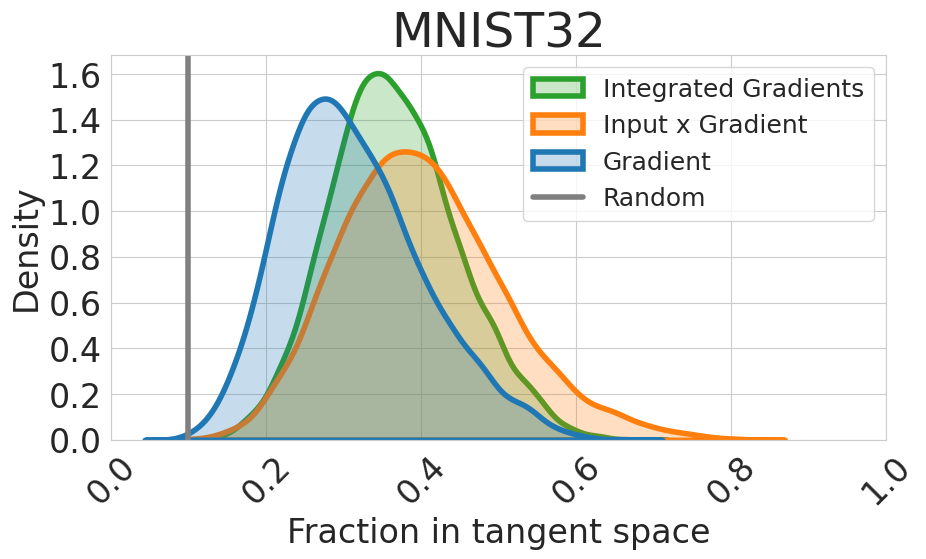

In [54]:
val_pair = []
for v in frac_grad_its:
    val_pair.append((v, 'Gradient'))
for v in frac_ixg_its:
    val_pair.append((v, 'Input x Gradient'))
for v in frac_int_grad_its:
    val_pair.append((v, 'Integrated Gradients'))
df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
sns.set_style('whitegrid')

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Value', hue='Method', fill=True, legend=False, lw=4, alpha=0.25)
plt.axvline(np.sqrt(10 / 32**2), 0, 1.4, label='Random', color='gray', lw=4)
plt.legend(labels=['Integrated Gradients', 'Input x Gradient', 'Gradient', 'Random'], fontsize=18)
plt.xlim([0., 1.0])
plt.xticks(fontsize=24, rotation=45)
plt.xlabel('Fraction in tangent space', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.title('MNIST32', fontsize=35)
plt.show()